<a href="https://colab.research.google.com/github/TarnNished/deep_learning_final/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import os
import json
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt


In [153]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [154]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BASE_DIR = "/content/drive/MyDrive/artifacts"

ARTIFACTS_DIR = BASE_DIR
IMAGE_DIR = "/content/drive/MyDrive/caption_data/Images"


CONFIG = json.load(open(os.path.join(ARTIFACTS_DIR, "config.json")))
vocab = json.load(open(os.path.join(ARTIFACTS_DIR, "vocab.json")))
ivocab = {int(i): w for w, i in vocab.items()}

bos = vocab["<bos>"]
eos = vocab["<eos>"]
pad = vocab["<pad>"]

print("Artifacts loaded")


Artifacts loaded


In [155]:
import os, json

CONFIG = json.load(open(os.path.join(ARTIFACTS_DIR, "config.json")))
vocab = json.load(open(os.path.join(ARTIFACTS_DIR, "vocab.json")))

ivocab = {int(idx): word for word, idx in vocab.items()}

bos = vocab["<bos>"]
eos = vocab["<eos>"]
pad = vocab["<pad>"]

print("Artifacts loaded correctly")


Artifacts loaded correctly


In [156]:
transform = transforms.Compose([
    transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [157]:
class Encoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        resnet = models.resnet18(pretrained=False)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        self.conv_proj = nn.Conv2d(512, embed_dim, kernel_size=1)

    def forward(self, images):
        feats = self.backbone(images)
        feats = self.conv_proj(feats)
        feats = feats.flatten(2).permute(0, 2, 1)
        return feats


class Attention(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.encoder_att = nn.Linear(embed_dim, hidden_dim)
        self.decoder_att = nn.Linear(hidden_dim, hidden_dim)
        self.full_att = nn.Linear(hidden_dim, 1)

    def forward(self, encoder_feats, hidden_state):
        att1 = self.encoder_att(encoder_feats)
        att2 = self.decoder_att(hidden_state).unsqueeze(1)
        scores = self.full_att(torch.tanh(att1 + att2))
        alpha = torch.softmax(scores, dim=1)
        context = (encoder_feats * alpha).sum(dim=1)
        return context, alpha


class DecoderWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.attention = Attention(embed_dim, hidden_dim)
        self.lstm = nn.LSTMCell(embed_dim * 2, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.init_h = nn.Linear(embed_dim, hidden_dim)
        self.init_c = nn.Linear(embed_dim, hidden_dim)

    def init_hidden(self, encoder_feats):
        mean_feats = encoder_feats.mean(dim=1)
        return self.init_h(mean_feats), self.init_c(mean_feats)


In [158]:
encoder = Encoder(CONFIG["embedding_dim"]).to(DEVICE)
decoder = DecoderWithAttention(
    len(vocab),
    CONFIG["embedding_dim"],
    CONFIG["hidden_dim"]
).to(DEVICE)

checkpoint = torch.load(os.path.join(ARTIFACTS_DIR, "model.pt"), map_location=DEVICE)
encoder.load_state_dict(checkpoint["encoder"])
decoder.load_state_dict(checkpoint["decoder"])

encoder.eval()
decoder.eval()

# REQUIRED: model object
model = {
    "encoder": encoder,
    "decoder": decoder
}

print("Model loaded")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded


In [159]:
def generate_caption(image_path: str, model: any) -> str:
    encoder = model["encoder"]
    decoder = model["decoder"]

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(DEVICE)

    BEAM_SIZE = 3

    with torch.no_grad():
        encoder_feats = encoder(image)
        h, c = decoder.init_hidden(encoder_feats)

        beams = [([bos], 0.0, h, c)]
        completed = []

        for _ in range(CONFIG["max_len"]):
            new_beams = []

            for tokens, score, h, c in beams:
                if tokens[-1] == eos:
                    completed.append((tokens, score))
                    continue

                last = tokens[-1]
                emb = decoder.embedding(torch.tensor([last], device=DEVICE))
                context, _ = decoder.attention(encoder_feats, h)

                h_new, c_new = decoder.lstm(
                    torch.cat([emb, context], dim=1),
                    (h, c)
                )

                logits = decoder.fc(h_new)

                # repetition penalty (soft)
                for t in set(tokens):
                    logits[0, t] /= 1.1

                log_probs = torch.log_softmax(logits, dim=1)
                topk = torch.topk(log_probs, BEAM_SIZE)

                for i in range(BEAM_SIZE):
                    new_beams.append((
                        tokens + [topk.indices[0, i].item()],
                        score + topk.values[0, i].item(),
                        h_new.clone(),
                        c_new.clone()
                    ))

            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:BEAM_SIZE]
            if not beams:
                break

        best = max(
            completed + beams,
            key=lambda x: x[1] / (len(x[0]) ** 0.7)
        )[0]

        words = [
            ivocab[t] for t in best
            if t not in {bos, eos, pad}
        ]

    return " ".join(words)


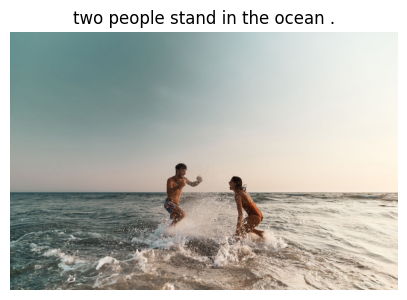

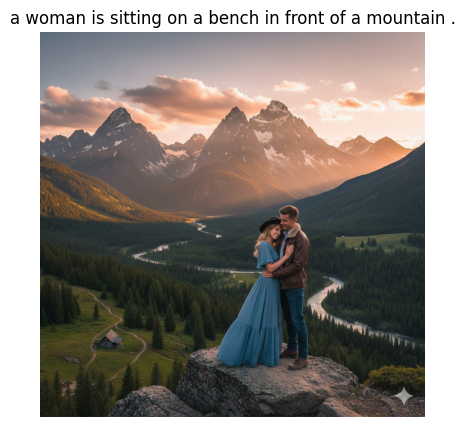

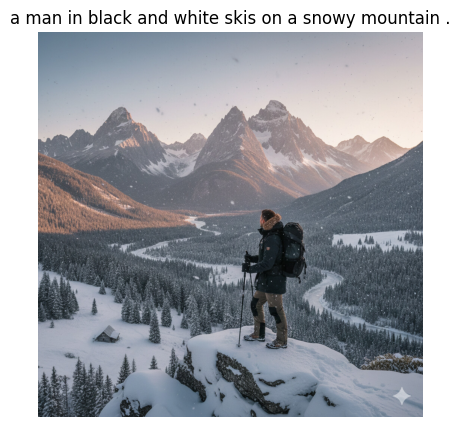

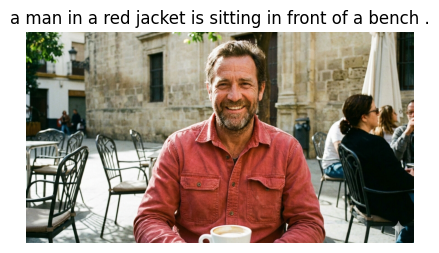

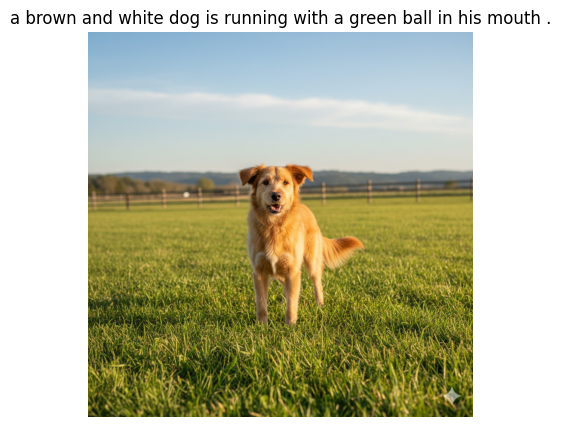

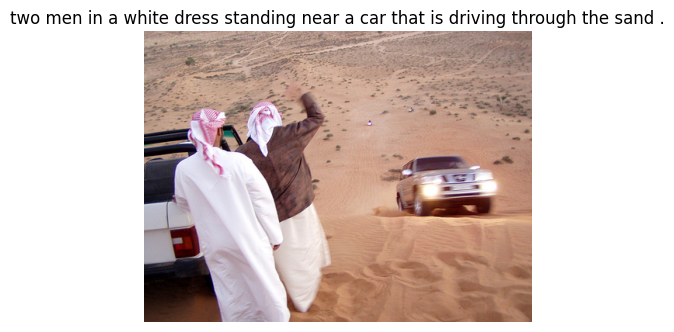

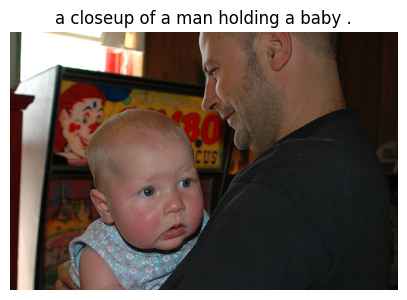

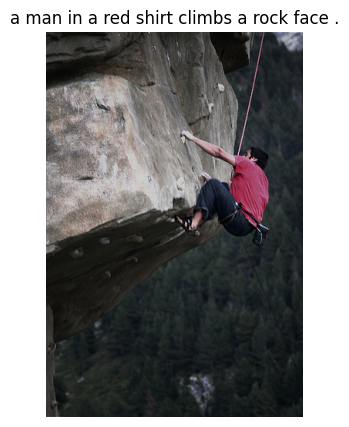

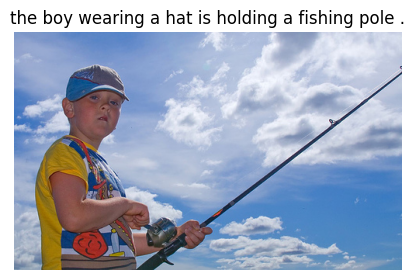

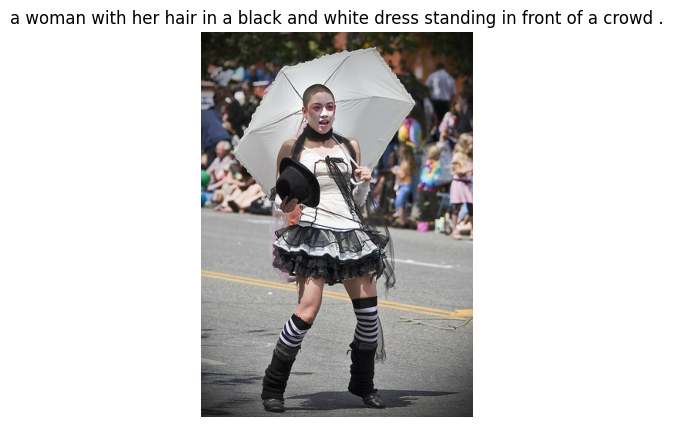

In [160]:
# test images are new unseen images, other 5 are already seen ones.

test_images = [
    "test1.jpg",
    "test2.jpg",
    "test3.jpg",
    "test4.jpg",
    "test5.jpg",
    "97105139_fae46fe8ef.jpg",
    "965444691_fe7e85bf0e.jpg",
    "997722733_0cb5439472.jpg",
    "933118213_b35b0b62a7.jpg",
    "972381743_5677b420ab.jpg"

]

for img_name in test_images:
    path = os.path.join(IMAGE_DIR, img_name)
    caption = generate_caption(path, model)

    img = Image.open(path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(caption)
    plt.show()


In [161]:
analysis = {
    "successful_examples": [
        "The model correctly identifies main objects, has gramatically correct answers in most cases"
    ],
    "failure_cases": [
        "Model strugles to identify details in unseen images, often can get the scene or detials like gender wrong"
    ]
}

for k, v in analysis.items():
    print(k.upper())
    for item in v:
        print("-", item)
    print()


SUCCESSFUL_EXAMPLES
- The model correctly identifies main objects, has gramatically correct answers in most cases

FAILURE_CASES
- Model strugles to identify details in unseen images, often can get the scene or detials like gender wrong

